# Deep Learning with MXNet Gluon - Assignment 1

## Assignment Description


Welcome to Deep Learning with MXNet/Gluon Week 1 assignment. This assignment will focus mainly on review of some prerequisites and the fundamentals of training neural networks. The first two questions will refresh our linear algebra with the help of `mxnet.ndarray`, and differential calculus with the help of `mxnet.autograd`. In the remaining questions, you will train a deep learning model to predict category of item of clothing from images. You will make use of the `gluon.Dataset` and `gluon.DataLoader` library for managing the training data, `gluon.HybridBlock` for creating your neural network model, and finally `gluon.Trainer` for training the model on your dataset.

### Supplemental Reading
* [Gluon Crash Course Videos](https://www.youtube.com/playlist?list=PLkEvNnRk8uVmVKRDgznk3o3LxmjFRaW7s)
* [Linear Regression (Dive into deep learning)](https://d2l.ai/chapter_linear-networks/index.html)
* [Multilayer Perceptron (Dive into deep learning)](https://d2l.ai/chapter_multilayer-perceptrons/index.html)
* [Deep Learning Computation (Dive into deep learning)](https://d2l.ai/chapter_deep-learning-computation/index.html)

In [1]:
#dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header = None, sep='\s+')
data.columns = ['CRIM','ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT', 'MEDV']
X_train = data.loc[:, data.columns[:len(data.columns)-1]].values
y_train = data.loc[:, data.columns[-1]].values

def solve_ols_numpy(X, y):
    X = np.hstack((X, np.ones((data.shape[0], 1))))
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

## Least squares Linear Regression

You are probably familiar with linear regression and maybe have used libraries like sklearn or numpy to implement linear regression models. Here, we will implement the analytic solution to least squares linear regression using the mxnet `ndarray`. As you learned in lecture today, mxnet `ndarray` is similar to numpy `ndarray` and has support for performing matrix operations.

The linear regression approach to modelling is to make the assumption that the relationship between your target variable (label) and your input variables (data) is linear. This relationship can be expressed mathematically, as

$$ \hat{y} = \mathtt{Xw + w_0}$$

where $\mathtt{X}$ is your data, $\hat{y}$ is your predicted label, $\mathtt{w}$ is a vector of weights or coefficients for each column in the dataset, and $\mathtt{w_0}$ is the intercept or bias.


If we let $ X = [\mathtt{X}, \mathtt{1}]$ and $w = [\mathtt{w, w_0}]$ then we can rewrite the above equation and simplify to just a simple matrix multiplication as 

$$ \hat{y} = Xw$$


To find the value of the weights $w$, we have to solve an optimization problem involving a loss function that tells how good our predictions are. The loss function we will be using is the least squares loss or l2 loss and it is given as
    $$f(w) = ||Xw - y||^2$$ 
where $||.||$ denotes the $L_2$ norm and $y$ is your actual label value.

The $w$ that minimizes the function above has a closed form solution and it is given as:

$$ w = (X^TX)^{-1}X^Ty $$
    

## Question 1 
Write code to calculate the value of $w$ using the close form solution above given the data matrix $\mathtt{X}$ and data labels $y$ using mxnet `ndarray`. It might make things easier if you organize your code in a function like `solve_ols_numpy` above. Here are some guidelines to help with the implementation.

* First create `mxnet.ndarray` representations of X_train and y_train
* Don't forget to create an `mxnet.ndarray` column vector of ones, for the intecept, with the same number of rows as X_train and concatenate X_train with the column vector of ones
* Use the `mxnet.nd.linalg.potri` and `mxnet.nd.linalg.potrf` functions to compute the inverse. For example to compute the inverse of a matrix M, you can run `nd.linalg.potri(nd.linalg.potrf(M))`. MXNet does not have a generic matrix inverse operator because all operators need to be differentiable, but luckily our Gramian matrix $X^TX$ is symmetric and positive definite so we can use the [cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) to compute its inverse.

Compare your results with the results of using the pure numpy `solve_ols_numpy` function defined above.

Try timing your code and then changing the contexts of your mxnet ndarrays to gpu. Did you notice any speed difference. Can you explain the difference in speed? Also time how long `solve_ols_numpy` takes to run. What do you observe?

In [2]:
# Answer 1 
import mxnet as mx
from mxnet import nd

# Your code here
def solve_ols_mxnet(X, y, ctx=mx.cpu()):
    X = nd.concat(X, nd.ones((X.shape[0], 1), ctx=ctx), dim=1)
    return nd.dot(nd.dot(nd.linalg.potri(nd.linalg.potrf(nd.dot(X.T, X))), X.T), y)

In [3]:
%%time
print(solve_ols_numpy(X_train, y_train))

[-1.08011358e-01  4.64204584e-02  2.05586264e-02  2.68673382e+00
 -1.77666112e+01  3.80986521e+00  6.92224640e-04 -1.47556685e+00
  3.06049479e-01 -1.23345939e-02 -9.52747232e-01  9.31168327e-03
 -5.24758378e-01  3.64594884e+01]
CPU times: user 79.3 ms, sys: 78.9 ms, total: 158 ms
Wall time: 54.6 ms


In [4]:
X_train, y_train = nd.array(X_train), nd.array(y_train)

In [5]:
%%time
print(solve_ols_mxnet(X_train, y_train))


[-1.0800998e-01  4.6421096e-02  2.0573609e-02  2.6868079e+00
 -1.7764294e+01  3.8105152e+00  6.8673119e-04 -1.4754937e+00
  3.0600709e-01 -1.2332764e-02 -9.5259166e-01  9.3131931e-03
 -5.2472472e-01  3.6449818e+01]
<NDArray 14 @cpu(0)>
CPU times: user 1.31 s, sys: 1.12 s, total: 2.43 s
Wall time: 169 ms


In [6]:
X_train, y_train = X_train.as_in_context(mx.gpu(0)), y_train.as_in_context(mx.gpu(0))

In [7]:
%%time
print(solve_ols_mxnet(X_train, y_train, ctx=mx.gpu(0)))


[-1.0801238e-01  4.6418693e-02  2.0572171e-02  2.6867003e+00
 -1.7768848e+01  3.8096497e+00  6.9505069e-04 -1.4755456e+00
  3.0606851e-01 -1.2334810e-02 -9.5284563e-01  9.3108136e-03
 -5.2476704e-01  3.6463341e+01]
<NDArray 14 @gpu(0)>
CPU times: user 545 ms, sys: 272 ms, total: 817 ms
Wall time: 816 ms


## Answer 1

Your answer here

## Gradient descent with `autograd`

Earlier, we saw how to use `mxnet.ndarray` operations to solve ordinary least squares linear regression. Luckily we were able to do this because a closed-form solution exists for minimizing our loss function. In general, we are not always so lucky that a closed form solution exists. For example if we modify the loss function above slightly to include an $L_1$ regularization term like 

$$f(w) = \frac{1}{n}||Xw - y||_2^2 + \lambda||w||_1$$

then no closed form solution exists. 

Instead, we can turn to a trusted general-purpose algorithm for minimizing any arbitrary function that has a derivative - gradient descent. gradient descent is an iterative algorithm that starts with an initialization for the values of our weights and successively refines the values of the weights by moving them in the direction of the negative gradient. 

Take a look again at the loss function above. Can you compute the derivative for it? If your answer is no, then no need to fret. That's what `autograd` is here for. We will implement gradient descent to solve the $L_1$ regularized version of OLS using only `mnxet.ndarray` and `mxnet.autograd` and you won't have to compute any derivatives by hand.

## Question 2

Write code to calculate the value of $w$ using minibatch gradient descent given the data matrix $\mathtt{X}$ and data labels $y$.  Here are some guidelines to help with the implementation.

* Fill in the code for the loss function which simply computes the $L_1$ regularized loss above
* Fill in the code for the optimize function which performs a single gradient descent update step. Make sure the weight changes are in place. Also normalize the gradient by the batch-size
* Fill in the code for the train function using the default parameters in the argument.
    * Initialize w with a standard normal distribution
    * In your training loop, use the autograd scope to record the computations need to compute the loss so you can compute the gradient
 


Text(0, 0.5, 'Mean loss')

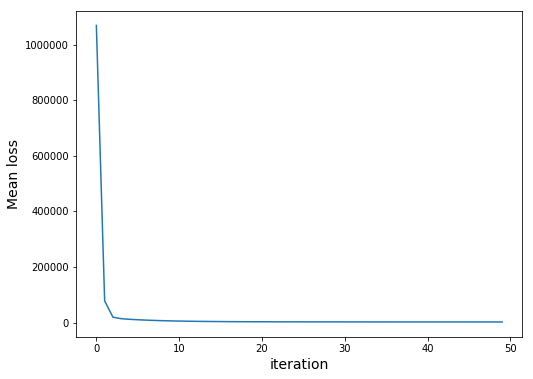

In [8]:
from mxnet import autograd

def loss_fn(X, w, y, lambd):
    # Your code here
    return nd.mean((nd.dot(X, w) - y)**2) + lambd*nd.norm(w, ord=1)

def optimize(w, lr, batch_size):
    # Your code here
    w -= (lr/batch_size) * w.grad

def train(X, y, lambd=0.1, lr=0.001, batch_size=506, epochs=50, ctx=mx.cpu()):
    loss_sequence = []
    
    # Your code here
    
    X, y = nd.array(X, ctx=ctx), nd.array(y, ctx=ctx)
    X = nd.concat(X, nd.ones((X.shape[0], 1), ctx=ctx), dim=1)
    w = nd.random_normal(shape=(X.shape[1],1), ctx=ctx)
    w.attach_grad()
    
    for epoch in range(epochs):
        with autograd.record():
            l = loss_fn(X, w, y, lambd)
        l.backward()
        optimize(w, lr, batch_size)
        loss_sequence.append(l.asscalar())
        
    # end implementation
    return loss_sequence

losses = train(X_train, y_train)

plt.figure(num=None,figsize=(8, 6))
plt.plot(losses)
plt.xlabel('iteration',fontsize=14)
plt.ylabel('Mean loss',fontsize=14)
    

## Answer 2

Your answer here

## Fashion MNIST

The most commonly used image classification data set is the MNIST handwritten digit recognition data set, proposed by LeCun, Cortes and Burges in the 1990s. However, even simple (shallow) models achieve classification accuracy over 95% on MNIST. In order to get a better intuition, we will use the qualitatively similar, but comparatively complex Fashion-MNIST dataset, proposed by Xiao, Rasul and Vollgraf in 2017. The goal is no longer to classify numbers, but clothing types instead.

The dataset can be automatically downloaded through Gluon's data.vision.datasets module. The following code downloads the training dataset and shows the first example.

Number of images: 60000


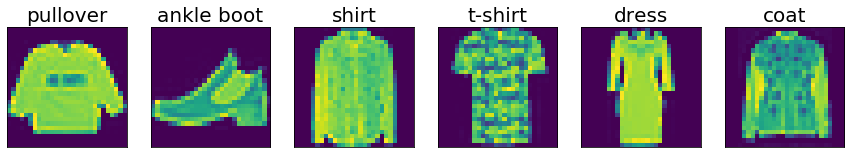

In [9]:
from mxnet import gluon
from mxnet.gluon.data.vision import datasets

fashion_mnist_train = datasets.FashionMNIST(train=True)
fashion_mnist_valid = datasets.FashionMNIST(train=False)

print("Number of images: %d" % len(fashion_mnist_train))

text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]
def plot_images(X, y):
    # plot images
    _, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
    for f,x,yi in zip(figs, X,y):
        # 3D->2D by removing the last channel dim
        f.imshow(x.reshape((28,28)).asnumpy())
        ax = f.axes
        ax.set_title(text_labels[int(yi)])
        ax.title.set_fontsize(20)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
X, y = fashion_mnist_train[0:6]
plot_images(X, y)

## Question 3

The training and validation dataset and stored into a gluon `dataset`. However, in order to get good performance on our dataset, we must do some preprocessing on the data. For example, We will have to normalize the image data.

Write code to using `transforms.Compose` to convert the images to tensor representation in `CHW` format and then normalize the dataset. Take a look at [ToTensor](https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.vision.transforms.ToTensor) and [Normalize](https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.vision.transforms.Normalize) to learn how to do this. To normalize, use the `normalize_mean` and `normalize_stdev` variables provided below. 

Next, write code to create a `gluon.data.DataLoader` that's able to take batches of data from your transformed dataset and feed into your network. Use the batch_size variable provided below. Make sure the **training** dataloader shuffles the data at each epoch.

After transforming your dataset, what is the shape of each training image.

In [10]:
from mxnet.gluon.data.vision import transforms
batch_size = 256
normalize_mean = 0.13
normalize_stdev = 0.31

# Your code here.

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])



train_data = gluon.data.DataLoader(fashion_mnist_valid.transform_first(transformer),
                                   batch_size=batch_size, 
                                   shuffle=True, 
                                   num_workers=4)

valid_data = gluon.data.DataLoader(fashion_mnist_valid.transform_first(transformer),
                                   batch_size=batch_size, 
                                   num_workers=4)

## LeNet

Now it's time to construct our neural network architecture. Since we are dealing with image data we will get better performance on this dataset with a convolutional neural network. We will go into the details of designing Convolutional Neural Networks in the next class but for now we will be using a specific network known as [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) network architeture introduced by LeCun et al for the handwritten digit recognition on the MNIST data set. The network has the following structure: 2 convolutional blocks, 2 fully connected hidden layers and an output layer. A typical convolutonal block consists of A convolution layer, followed by the activation function and then a pooling layer. 

![lenet](https://cdn-images-1.medium.com/max/2400/1*1TI1aGBZ4dybR6__DI9dzA.png)

The LeNet paper used `tanh` as the activation functions, but we will use `relu` here since it's easy to train and gives better performance typically. We will also use max pooling since it works better in practice as well.

We will initialize the parameters of network with the Xavier initialization method which is a popular choice for convolutional neural networks.


## Question 4

Write code to compute the forward pass of the network by filling in the `hybrid_forward` function below.

Here are some guidelines. 
* Remember to apply the activation function `relu` on the outputs of the convolution layer before applying the pool layer.
* Reshape the output of the second convolutional block so that you have a flat vector that goes into your fully connected layers. 


In [11]:
from mxnet.gluon import nn, HybridBlock

class LeNet(HybridBlock):
    def __init__(self):
        super(LeNet, self).__init__()
        with self.name_scope():
            self.conv1 = nn.Conv2D(channels=6, kernel_size=5)
            self.pool1 = nn.MaxPool2D(pool_size=2, strides=2)
            self.conv2 = nn.Conv2D(channels=16, kernel_size=3)
            self.pool2 =  nn.MaxPool2D(pool_size=2, strides=2)
            self.hidden1 = nn.Dense(120)
            self.hidden2 = nn.Dense(84)
            self.out = nn.Dense(10)
    
    def hybrid_forward(self, F, x):
        ## your code here
        feature_maps_1 = self.pool1(F.relu(self.conv1(x)))
        feature_maps_2 =self.pool2(F.relu(self.conv2(feature_maps_1)))
        flat = feature_maps_2.reshape((0, -1))
        hidden = F.relu(self.hidden2(F.relu(self.hidden1(flat))))
        return self.out(hidden)

net = LeNet()
net.initialize(mx.init.Xavier())
print(net)

LeNet(
  (conv1): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (conv2): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (hidden1): Dense(None -> 120, linear)
  (hidden2): Dense(None -> 84, linear)
  (out): Dense(None -> 10, linear)
)


## Time to train

## Question 5
Now, write code to perform the training loop. Use the gluon `SoftmaxCrossEntropyLoss` loss function and `sgd` optimizer with a learning rate of `0.1`. Run training for 10 epochs and plot the training and validation accuracy at each epoch.

Try out different optimizers and values for the learning rate. Does your accuracy change? The learning rate and choice of optimizer are known as hyperparameters as they are parameters that are not learned by the network but can influence the values of the learned parameters and as such the performance of the network. Briefly, describe you might try to optimizer the values for the hyperparameters.

In [12]:
from time import time

def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    acc = (output.argmax(axis=1) == label.astype('float32'))
    return acc.mean().asscalar()

# Your code here
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.1})

losses, train_accuracies, validation_accuracies = [], [], []

for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time()
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        
        trainer.step(batch_size)
        
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)
    
    for validation_data, validation_label in valid_data:
        validation_output = net(validation_data)
        valid_acc += acc(validation_output, validation_label)
        
  
    print("Epoch[%d] Loss:%.3f Acc:%.3f|%.3f Perf: %.1f img/sec"%(
        epoch, train_loss/len(train_data),
        train_acc/len(train_data),
        valid_acc/len(valid_data), 
        len(fashion_mnist_train)/(time()-tic)))
    
    losses.append(train_loss/len(train_data))
    train_accuracies.append(train_acc/len(train_data) )
    validation_accuracies.append(valid_acc/len(valid_data))


Epoch[0] Loss:1.638 Acc:0.438|0.666 Perf: 58681.9 img/sec
Epoch[1] Loss:0.810 Acc:0.695|0.759 Perf: 62190.0 img/sec
Epoch[2] Loss:0.646 Acc:0.752|0.797 Perf: 65632.3 img/sec
Epoch[3] Loss:0.558 Acc:0.790|0.798 Perf: 63744.6 img/sec
Epoch[4] Loss:0.523 Acc:0.805|0.791 Perf: 63099.1 img/sec
Epoch[5] Loss:0.484 Acc:0.818|0.823 Perf: 65081.5 img/sec
Epoch[6] Loss:0.448 Acc:0.833|0.846 Perf: 66583.4 img/sec
Epoch[7] Loss:0.445 Acc:0.833|0.847 Perf: 64444.7 img/sec
Epoch[8] Loss:0.407 Acc:0.847|0.850 Perf: 66002.6 img/sec
Epoch[9] Loss:0.394 Acc:0.854|0.854 Perf: 64796.4 img/sec


(0, 1)

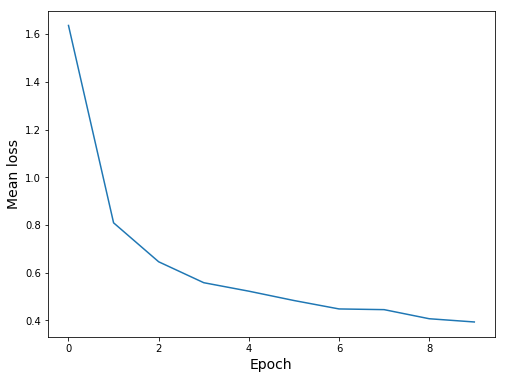

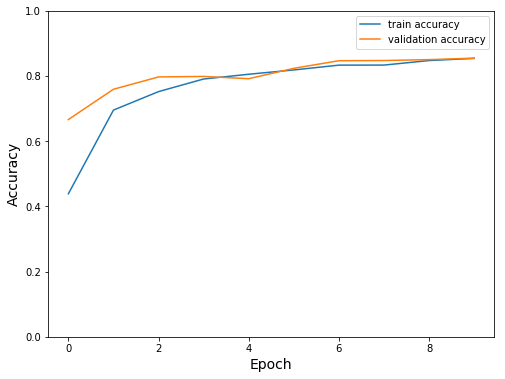

In [13]:
plt.figure(num=None,figsize=(8, 6))
plt.plot(losses)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Mean loss',fontsize=14)

plt.figure(num=None,figsize=(8, 6))
plt.plot(range(10), train_accuracies, range(10), validation_accuracies)
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend(['train accuracy', 'validation accuracy'])
plt.ylim([0, 1])